In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner

In [2]:
import xoflares
from flarefinder import *

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(xoflares.__version__)

0.1.6
1.0.4
3.6
0.1.0


In [4]:
l = Lightcurve()
l.add_data('YZ CMi')
#l.add_data(curve='https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018206045859-s0001-0000000441420236-0120-s_tp.fits')

code runs lc.flatten()


In [5]:
o = OddsRatioDetector(l)
lnO, ts = o.oddsratio()
flarelist, Nflares, maxlist = o.thresholder(lnO, thresh = 10, expand=0, returnmax=True)

In [6]:
print(len(flarelist))

59


In [7]:
print(maxlist)

[(18.790114534226436, 85), (380.2246035356118, 428), (77.19040524915184, 569), (181.78190456748285, 1026), (21.14929175910794, 1536), (10.782889678679938, 1578), (258.75365527369127, 1634), (101.11389829056208, 1901), (23.212144915248658, 2228), (18.725931461312598, 2252), (16.98505806709091, 2770), (793.2337835219107, 3261), (11.461356850267373, 3541), (13.35189983223638, 3935), (15.92032224745782, 4003), (477.20266798363036, 4297), (15.752332907018479, 4706), (12.131213963025829, 4711), (35.77479372721737, 4775), (15.406152301328056, 5731), (13.970989282632301, 6902), (10.295746357115231, 6905), (13.943340638239516, 7598), (21.677806835212696, 7671), (10.882387346292765, 7680), (32.34805726381005, 7799), (2773.06784223531, 8247), (350.06703345135, 8661), (113.8041235284617, 9010), (11.577316114357865, 9129), (11.368384738610368, 9360), (87.63404397528502, 9633), (11.238957861867156, 9813), (3545.235107002379, 9854), (386.3921948104311, 9967), (16.80260333973893, 10560), (12.376592282

In [8]:
l.time /=(24*3600)


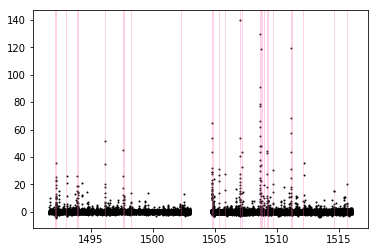

In [9]:
for i in flarelist:
    plt.axvspan(l.time[i[0]], l.time[i[1]], facecolor='hotpink', alpha = .3)

# plt.xlim(l.time.min,l.time.max)   
#plt.ylim(-.0001,.0001)
#plt.xlim(1504,1509)
#plt.xlim(1492.1,1492.3)   
plt.scatter(l.time, l.flux,s=1,c='k')

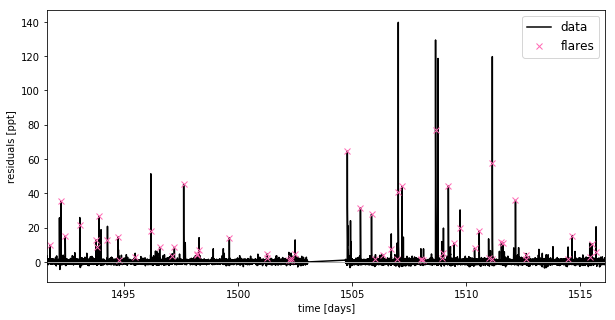

In [10]:
peaks = []
# amp = []

for i in range(len(maxlist)):
    peaks.append(maxlist[i][1])

# for i in range(len(maxlist)):
#     amp.append((maxlist[i][0]))
amp = l.flux[peaks]

plt.figure(figsize=(10, 5))
plt.plot(l.time, l.flux, "k", label="data")
plt.plot(l.time[peaks], l.flux[peaks], "x", color = "hotpink", label="flares")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=1)
#plt.xlim(1330,1335)
plt.xlim(l.time.min(), l.time.max());    

In [11]:
print(amp)

[ 9.75785932 35.38165548 14.87057908 21.31042711 12.89625344  8.84422141
 26.4858254  12.59196618 14.68104613  0.9787191   2.99356718 18.01119065
  8.41392533  3.52440503  8.37644745 45.29579107  4.43403154  4.09659708
  6.7525324  14.02005699  4.50927146  2.30369543  1.27938892  2.49288813
  1.28279879  4.63695747 64.51311363 31.40300829 27.81343144  1.83370846
  4.28360293  7.48724345  1.6162834  40.87132426 43.99708817  1.94272037
  0.88326356  0.88966539 76.96343581  1.97724223  5.02395676 44.21744434
 10.84132128 19.93762026  7.90549745 17.90637994  2.29063116  1.72783691
 57.53870797 11.41933691 11.13379844 35.80370888  1.63816553  3.95755498
  1.70386395 15.3705852   3.05108615 10.53261468  5.84833133]


In [12]:
#l.flux = (l.flux - 1.0)  * 1e3
# l.time = l.time/24*3600
### don't know what this is
# texp = lcf.hdu[1].header['FRAMETIM'] * lcf.hdu[1].header["NUM_FRM"]
# texp /= 60.0 * 60.0 * 24.0
texp = 0.001388888888888889
ref_time = 0.5 * (l.time.min() + l.time.max())
print(ref_time)

#lc.plot(normalize=False, ylabel='Relative flux [ppt]')

1503.8641948479585


In [13]:
# find some flares
# mflare = l.flux < 3.5 * np.sqrt(np.mean(l.flux**2))
# print(mflare)

cads = l.cadenceno - l.cadenceno[0]
x = l.time - ref_time
y = l.flux #  we're working with the data with a savgol subtracted


#number of points within each flare, get this from flarelist!
npts = []

for i in range(len(flarelist)):

    k = flarelist[i][1] - flarelist[i][0]
    npts.append(k)

        
tpeaks = x[peaks]
print(tpeaks)
ampls = amp
fwhms = np.asarray(npts) * (2/1440)
npeaks = Nflares


[-12.10898113 -11.63258221 -11.43674491 -10.80201058 -10.093665
 -10.03533072  -9.95755169  -9.5867126   -9.13253936  -9.09920556
  -8.36864056  -7.68668847  -7.29779573  -6.7491798   -6.6547346
  -6.24639824  -5.66861687  -5.66167239  -5.57278302  -4.24500043
  -2.60888971  -2.60472305  -1.64222693  -1.54083862  -1.5283387
  -1.36306196   0.92581449   1.50081397   1.98553509   2.15081235
   2.47164447   2.85080935   3.10080796   3.15775207   3.31469554
   4.14802266   4.15357817   4.25913281   4.79107225   5.0549584
   5.13690196   5.35356621   5.60634102   5.86606004   6.50077375
   6.70632635   7.11604236   7.25492905   7.27853979   7.67853318
   7.73825438   8.29518889   8.7562912    8.7632355   10.59791714
  10.77846819  11.55622537  11.64927833  11.8256622 ]


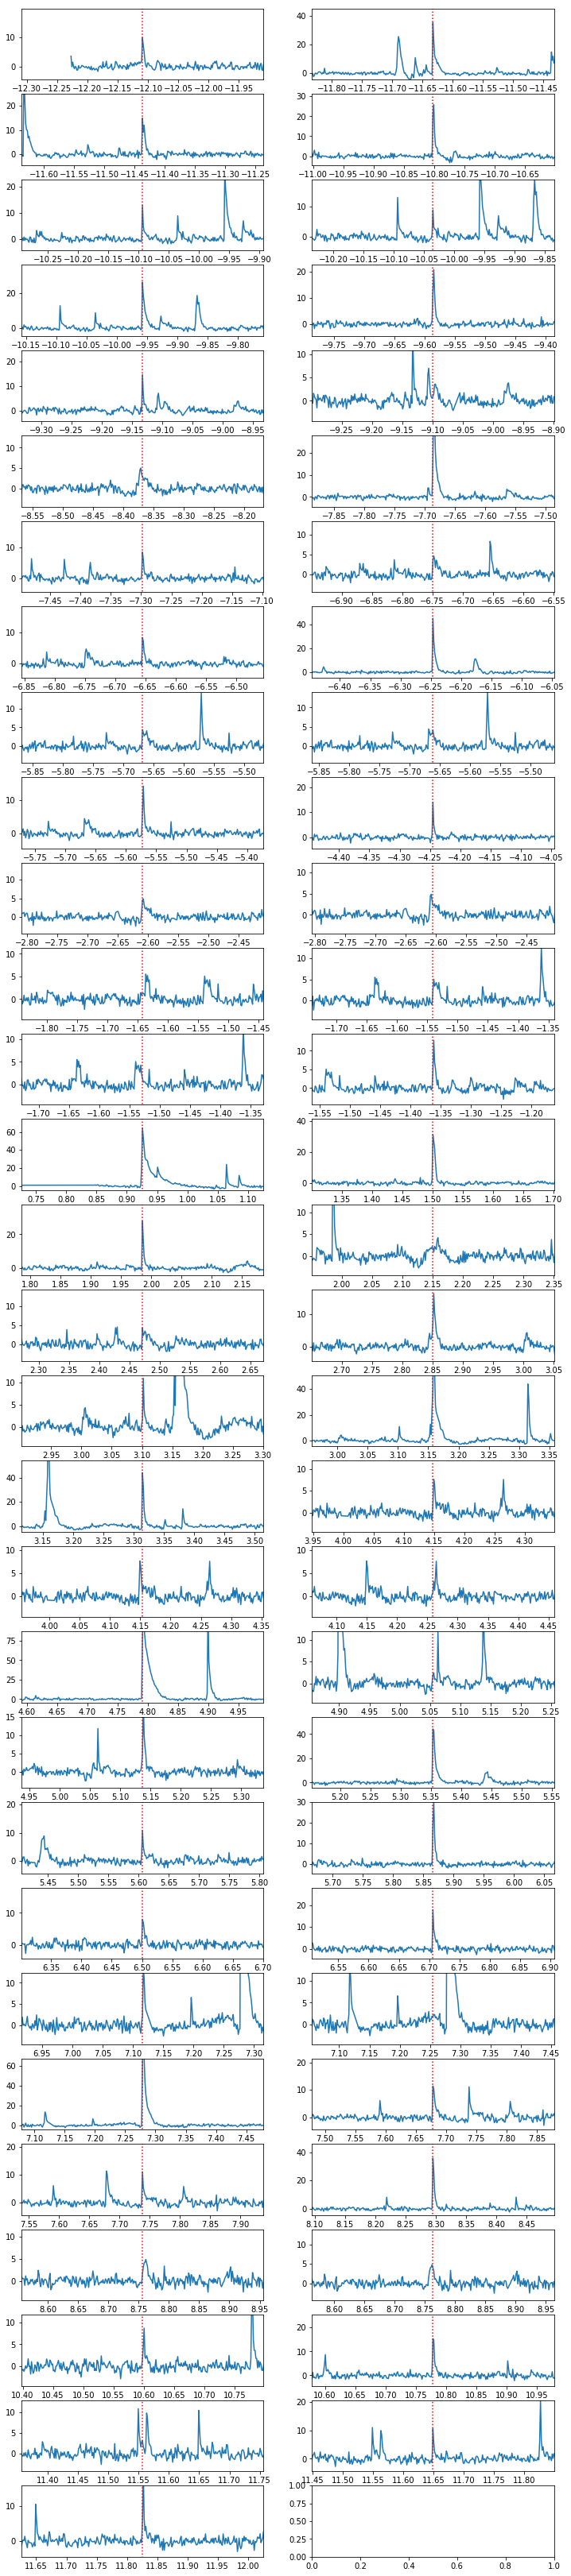

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+10))

Text(0, 0.5, 'power')

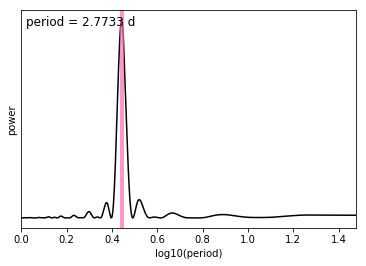

In [15]:
# determine the rotation period of the star
y = (l.raw_flux-1)*1e3
yerr = l.flux_error * 1e3

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="hotpink", lw=4, alpha=0.7)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

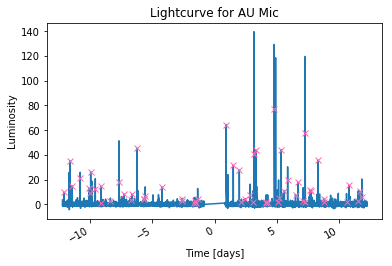

In [16]:
fig, ax = plt.subplots(1)
plt.title('Lightcurve for AU Mic')

ampls_1000 = np.array(ampls)/1000
plt.plot(x, l.flux)
plt.plot(tpeaks, ampls, "x", color = "hotpink", label="outliers")
fig.autofmt_xdate()
plt.xlabel('Time [days]')
plt.ylabel('Luminosity')
plt.show()

In [17]:
# GP model for smoothing using above period
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: -174122.41621487093 -> -44201.116318523294
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -44201.116318523294 -> -38126.04988379403


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -38126.04988379403 -> -37123.62100009006
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: -37123.62100009006 -> -36967.452322637895
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -36967.452322637895 -> -35647.695693533664


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -35647.695693533664 -> -34917.36550188649
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -34917.36550188649 -> -34626.29149914802
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -34626.29149914802 -> -34626.29149914802
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -34626.29149914802 -> -33479.87666093214
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -33479.87666093214 -> -32413.882775485392
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -32413.882775485392 -> -31113.264409464995
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -31113.264409464995 -> -30988.412418010616
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -30988.412418010616 -> -30704.746818290325
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -30704.746818290325 -> -30663.130489110004


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


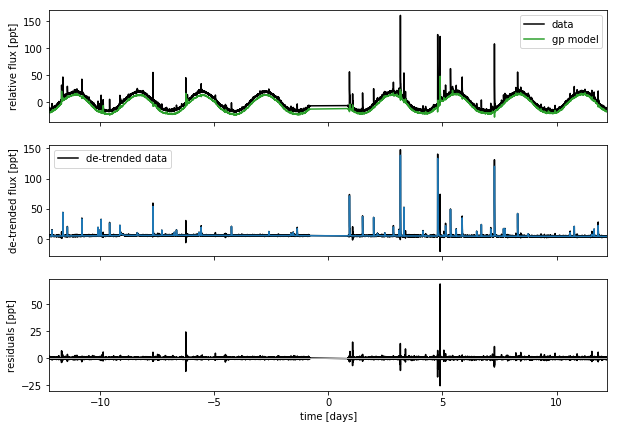

In [18]:
# plot the results of the model fitting + smoothing

def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

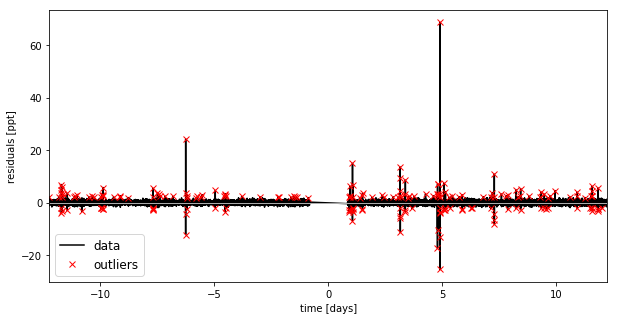

In [19]:
# subtract off the model to get residual (flatten light curve w/ spots/rotation removed)

mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -30663.130489110004 -> -30170.943713283956
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -30170.943713283956 -> -30009.82236379972
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -30009.82236379972 -> -29746.38247356262
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -29746.38247356262 -> -29377.17700171579
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -29377.17700171579 -> -29319.66567285047
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -29319.66567285047 -> -29201.54583390894
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -29201.54583390894 -> -29079.157511652946
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -29079.157511652946 -> -29079.157511652946
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -29079.157511652946 -> -29043.657332418225
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -29043.657332418225 -> -29005.720490422802
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -29005.720490422802 -> -28990.172143894273
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -28990.172143894273 -> -28986.040818710368
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -28986.040818710368 -> -28965.51974539371
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -28965.51974539371 -> -28965.39597395695


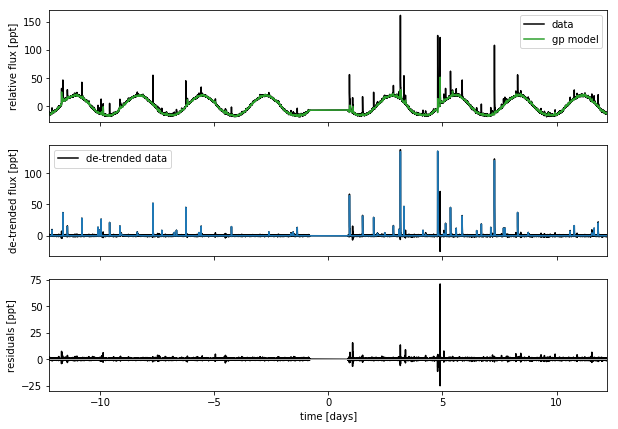

In [20]:

model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [21]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)


optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak', 'mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -28965.39597395695 -> -28965.376444253274


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [22]:
with model:
    mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Average Loss = 29,914: 100%|██████████| 100000/100000 [22:32:04<00:00,  4.04it/s]       
Finished [100%]: Average Loss = 29,915


In [23]:
with model:
    trace = mean_field.sample(3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Prot = 2.755639902945834 +0.03535841443832899 - 0.036223303038735555


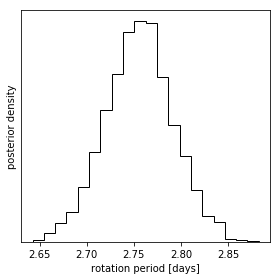

In [24]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('yzcmi-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))


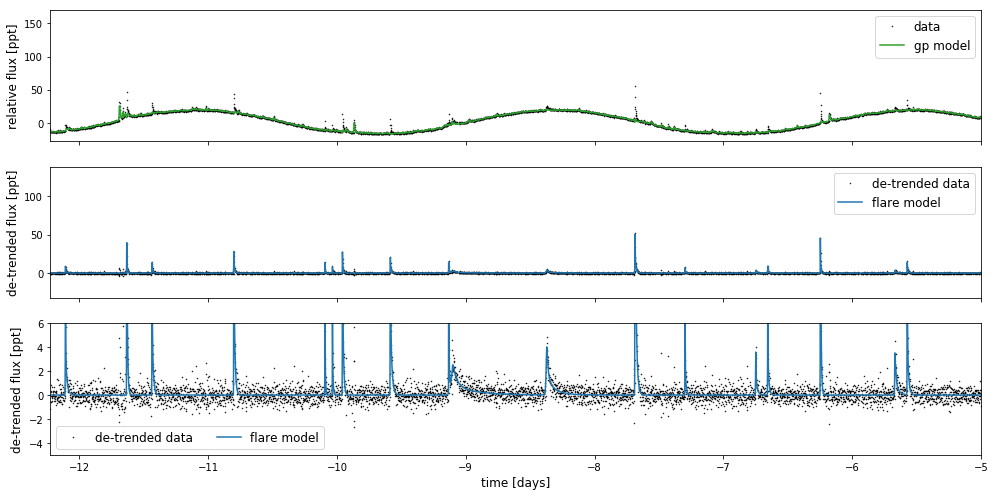

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-5,6)

ax.set_xlim(x.min(), -5)
#ax.set_xlim(0,10)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

In [70]:
print(x)
print(y)

[-12.22703925 -12.22565033 -12.22426141 ...  12.22426156  12.22565041
  12.22703925]
[ -9.79685783 -13.36246729 -11.81870699 ... -12.64441013 -11.78431511
 -11.99293137]


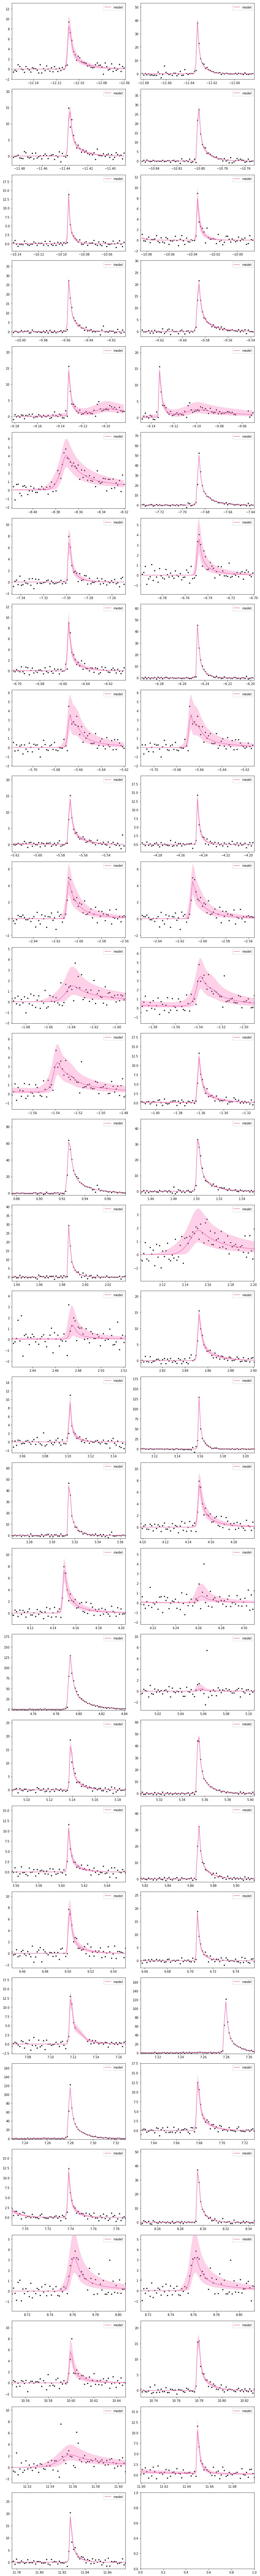

In [258]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.05) * (x < tpeaks[i]+0.05)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="hotpink", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="hotpink", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.05)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, .4*np.max(y[timemask]-gp_mod[timemask]) + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    

    fig.tight_layout()

In [29]:
# filename = 'flare_results_yz_cmi_peaks'
# outfile = open(filename,'wb')
# pickle.dump(peaks, outfile)
# outfile.close()

In [30]:
# filename = 'flare_results_yz_cmi_trace'
# outfile = open(filename,'wb')
# pickle.dump(trace,outfile)
# outfile.close()

In [31]:
# filename = 'flare_results_yz_cmi_x'
# outfile = open(filename,'wb')
# pickle.dump(x, outfile)
# outfile.close()

In [32]:
# filename = 'flare_results_yz_cmi_y'
# outfile = open(filename,'wb')
# pickle.dump(y, outfile)
# outfile.close()

In [292]:
# filename = 'flare_results_yz_cmi'
# outfile = open(filename,'wb')
# pickle.dump([x,y,peaks], outfile)
# outfile.close()

# import pickle
#x, y, peaks = pickle.load(open('flare_results_yz_cmi', 'rb'))
# test =  pickle.load(open('flare_results_yz_cmi', 'rb'))
# x = np.asarray(x)
# y = np.asarray(y)
# peaks = np.asarray(peaks)

# trace = pickle.load(open('flare_results_yz_cmi_trace'))
x = pickle.load(open('flare_results_yz_cmi_x', 'rb'))
y = pickle.load(open('flare_results_yz_cmi_y', 'rb'))
# peaks = pickle.load(open('flare_results_yz_cmi_peaks', 'rb'))

In [286]:
# print(test)

In [287]:
print(trace)

<MultiTrace: 1 chains, 3000 iterations, 18 variables>


In [298]:
def multiflaremodelnp(time, tpeaks, fwhms, ampls):
    time = np.asarray(time, dtype=float)
    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    multiflare_lc = np.zeros_like(time)
    npeaks = tpeaks.shape[0]
    for i in range(npeaks):
        flare_lc = _flaremodelnp(time, tpeaks[i], fwhms[i], ampls[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc


def get_light_curvenp(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = np.asarray(time, dtype=float)

    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    print(tpeaks, 'tpeaks')
    print(fwhms,'fwhms')
    print(ampls, 'ampls')

    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        texp = float(texp)
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = (dt + time.reshape(time.size, 1)).flatten()

    multiflare_lc = multiflaremodelnp(tgrid, tpeaks, fwhms, ampls)

    if texp is not None:
        multiflare_lc = np.mean(
            multiflare_lc.reshape(-1, oversample),
            axis=1)

    return multiflare_lc

def _flaremodelnp(time, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    flare_lc = np.zeros_like(time)
    flare_lc = np.where((time <= tpeak) * ((time - tpeak) / fwhm > -1.),
                        (_fr[0] +
                         _fr[1] * ((time - tpeak) / fwhm) +
                         _fr[2] * ((time - tpeak) / fwhm)**2. +
                         _fr[3] * ((time - tpeak) / fwhm)**3. +
                         _fr[4] * ((time - tpeak) / fwhm)**4.) *
                        ampl,
                        flare_lc
                        )
    flare_lc = np.where((time > tpeak) * ((time - tpeak) / fwhm < 20.),
                        (_fd[0] * np.exp(((time - tpeak) / fwhm) * _fd[1]) +
                         _fd[2] * np.exp(((time - tpeak) / fwhm) * _fd[3])) *
                        ampl,
                        flare_lc
                        )
    return flare_lc

In [299]:
def get_flare_integral(time, tpeak, fwhm, ampl, texp=None, oversample=7):
    """
    calculates the integral of flares. Useful for calculating
    equivalent width and energy
    this is designed to be a post processing step, not run within the
    HMC model. This is mostly because it is slightly awkward to implement
    and integral in theano
    """
    feval = get_light_curvenp(time,
                              tpeak,
                              fwhm,
                              ampl,
                              texp,
                              oversample)
    #check this line vvv will that help with negative energy values?
#     print(feval, 'feval')
#     print(len(time[feval > 0]), 'greater than 0 pts')
#     print(time[feval > 0])
    
    plt.scatter(time,feval)
    plt.show()
    tstart, tend = time[feval > 0][0], time[feval > 0][-1]
    print(tstart, 'tstart',tend, 'tend')
#     integral = integrate.quad(xoflares.get_light_curvenp, tstart, tend,
#                               points=tpeak,
#                               args=(tpeak, fwhm, ampl, texp, oversample))

    integral = np.trapz(feval, time)
    ### check ampl
    return integral

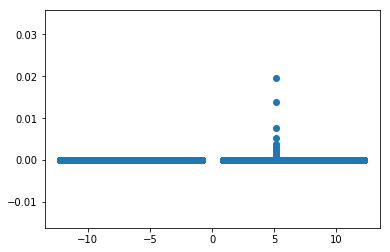

In [289]:
i = 40
feval = xoflares.get_light_curvenp(x, np.median(trace['tpeak'][:,i]),np.median(trace['fwhm'][:,i]),np.median((trace['ampl'][:,i]) + 1)/1000)
plt.scatter(x,feval)
x = pickle.load(open('flare_results_yz_cmi_x', 'rb'))
y = pickle.load(open('flare_results_yz_cmi_y', 'rb'))

test tpeak -12.108743681963603
[-12.10874368] tpeaks
[0.00328217] fwhms
[11.31354961] ampls


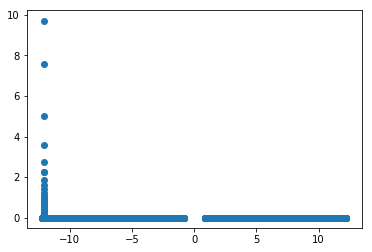

-12.111758972273265 tstart -12.043701950301283 tend
0.06807159064464435 e
test tpeak -11.63288860580613
[-11.63288861] tpeaks
[0.00148392] fwhms
[57.54696653] ampls


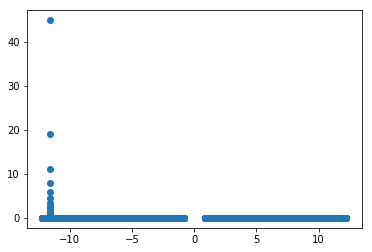

-11.633971122943194 tstart -11.603414942628888 tend
0.15389365860226256 e
test tpeak -11.436197799319562
[-11.4361978] tpeaks
[0.00259484] fwhms
[19.53776397] ampls


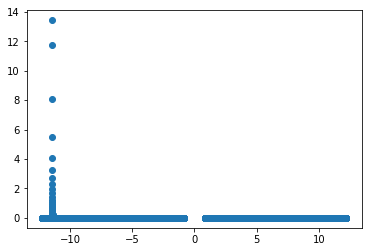

-11.43813382973326 tstart -11.385355002459164 tend
0.09077192643098697 e
test tpeak -10.801342356151622
[-10.80134236] tpeaks
[0.00217205] fwhms
[39.795835] ampls


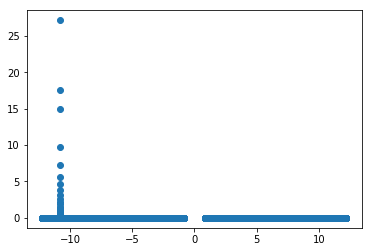

-10.803399491906703 tstart -10.758954239897548 tend
0.1530822516992782 e
test tpeak -10.094006950792778
[-10.09400695] tpeaks
[0.00095945] fwhms
[23.76056524] ampls


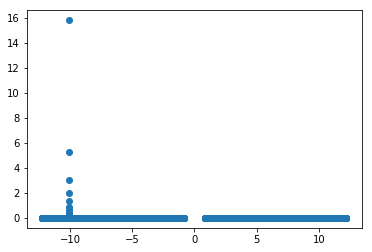

-10.093665004654667 tstart -10.075609153942196 tend
0.04146487509056989 e
test tpeak -10.035416496573497
[-10.0354165] tpeaks
[0.00130349] fwhms
[13.02573774] ampls


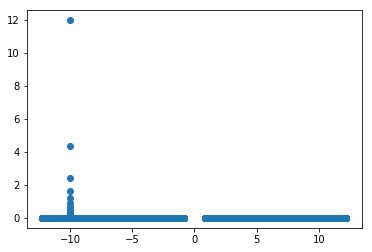

-10.036719633056236 tstart -10.010330317441685 tend
0.03470182182160966 e
test tpeak -9.957521853669313
[-9.95752185] tpeaks
[0.00186062] fwhms
[39.31540611] ampls


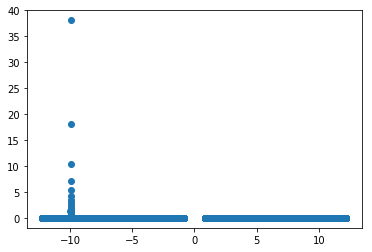

-9.958940602926532 tstart -9.92144000481062 tend
0.1431583044495049 e
test tpeak -9.585931584012567
[-9.58593158] tpeaks
[0.00304362] fwhms
[25.76424301] ampls


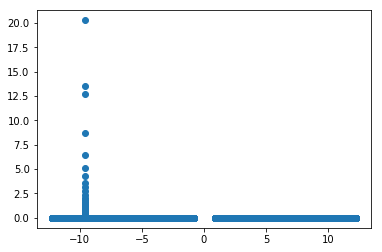

-9.588101511606283 tstart -9.525600575591398 tend
0.14076703604370122 e
test tpeak -9.132501878837456
[-9.13250188] tpeaks
[0.00103164] fwhms
[26.30963348] ampls


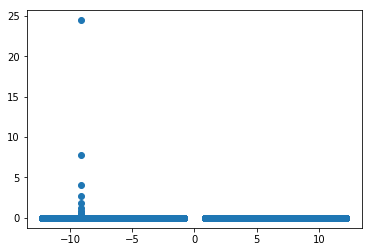

-9.132539358386339 tstart -9.113094643579188 tend
0.06193281959716389 e
test tpeak -9.100205858890813
[-9.10020586] tpeaks
[0.04799266] fwhms
[2.88955146] ampls


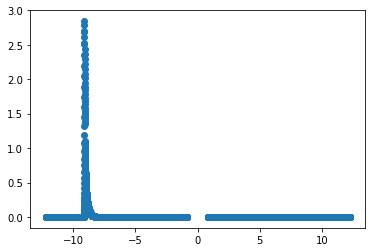

-9.147817349124807 tstart -8.140860104584362 tend
0.25284551371639097 e
test tpeak -8.371196641957553
[-8.37119664] tpeaks
[0.01656862] fwhms
[4.58428774] ampls


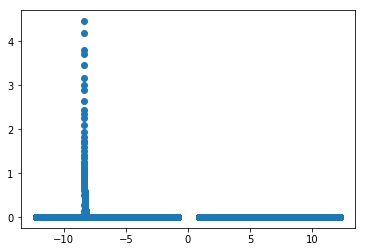

-8.386696333878945 tstart -8.040858968593056 tend
0.1384798382998146 e
test tpeak -7.685809766469774
[-7.68580977] tpeaks
[0.00261985] fwhms
[64.16755041] ampls


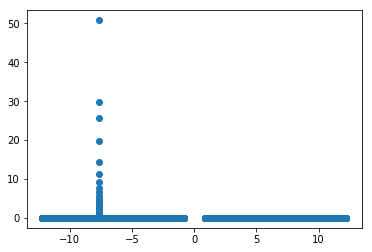

-7.688077376426008 tstart -7.633910150718293 tend
0.30127421004727484 e
test tpeak -7.297516690301757
[-7.29751669] tpeaks
[0.00172572] fwhms
[11.83483226] ampls


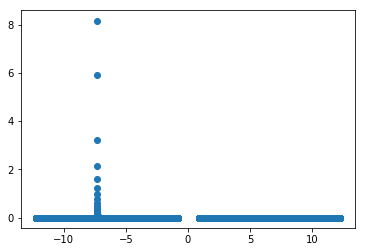

-7.299184630452373 tstart -7.263073180020001 tend
0.03771989656671403 e
test tpeak -6.748371573093429
[-6.74837157] tpeaks
[0.00342588] fwhms
[4.94055249] ampls


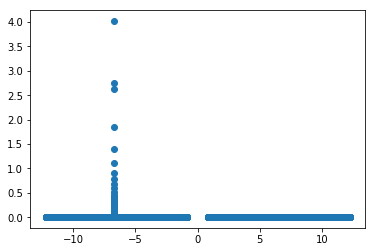

-6.750568697833842 tstart -6.681123694660073 tend
0.030482141831315115 e
test tpeak -6.6549961170098655
[-6.65499612] tpeaks
[0.00230297] fwhms
[11.97237645] ampls


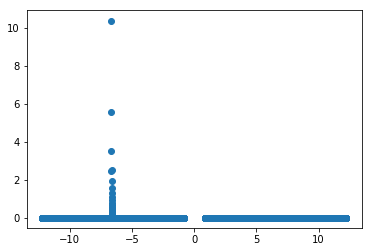

-6.656123496461532 tstart -6.610289803642445 tend
0.05033577975648963 e
test tpeak -6.246431269670872
[-6.24643127] tpeaks
[0.00129237] fwhms
[74.15923708] ampls


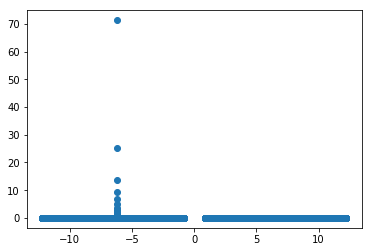

-6.24639823981056 tstart -6.22139806768746 tend
0.20242446575196701 e
test tpeak -5.668072805558932
[-5.66807281] tpeaks
[0.00320741] fwhms
[4.18448953] ampls


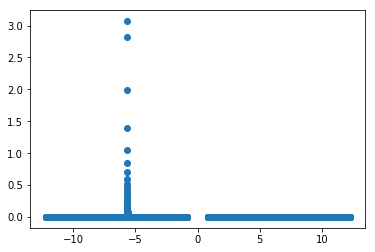

-5.670005770335365 tstart -5.604727638380382 tend
0.02417732687754143 e
test tpeak -5.662705909322408
[-5.66270591] tpeaks
[0.00645749] fwhms
[2.23671838] ampls


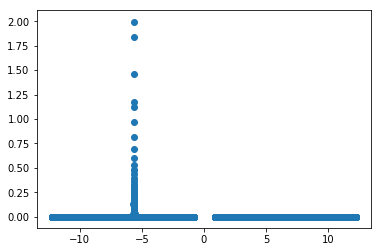

-5.668616874108238 tstart -5.5338939317639415 tend
0.02631397267141034 e
test tpeak -5.57194541342416
[-5.57194541] tpeaks
[0.00255154] fwhms
[18.09291941] ampls


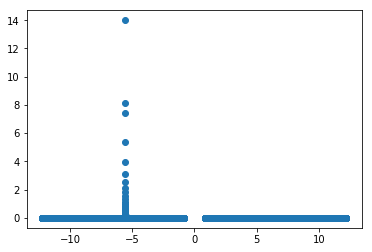

-5.574171920466824 tstart -5.52139386758904 tend
0.082526327783018 e
test tpeak -4.2450696422449425
[-4.24506964] tpeaks
[0.00102163] fwhms
[24.2285541] ampls


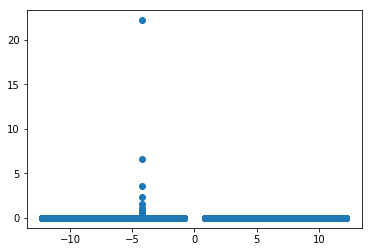

-4.245000433894802 tstart -4.2255559519178405 tend
0.05511607576996822 e
test tpeak -2.609073269734605
[-2.60907327] tpeaks
[0.00415078] fwhms
[5.38510141] ampls


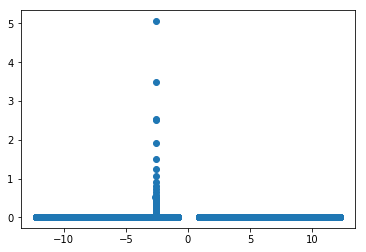

-2.613056363964688 tstart -2.5269454796552964 tend
0.04092885463283047 e
test tpeak -2.60432643437734
[-2.60432643] tpeaks
[0.00339499] fwhms
[1.53933318] ampls


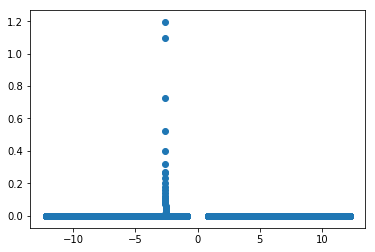

-2.607500822365182 tstart -2.5366676754752007 tend
0.009488760214799278 e
test tpeak -1.639781707284779
[-1.63978171] tpeaks
[0.01806048] fwhms
[1.96296321] ampls


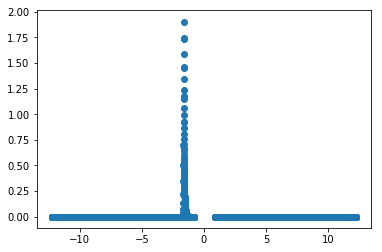

-1.6575046189318527 tstart -1.2797291843785388 tend
0.06461100592101197 e
test tpeak -1.538773057947505
[-1.53877306] tpeaks
[0.01097861] fwhms
[3.86291249] ampls


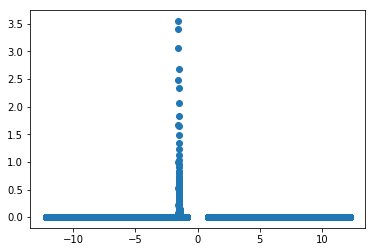

-1.5491719062954417 tstart -1.320006688328931 tend
0.07721599358726408 e
test tpeak -1.5286149517359418
[-1.52861495] tpeaks
[0.00274489] fwhms
[0.90688836] ampls


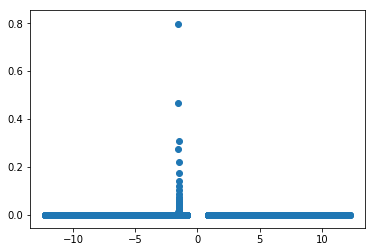

-1.5311164583799837 tstart -1.4741723599008765 tend
0.004540867045620575 e
test tpeak -1.361950749192848
[-1.36195075] tpeaks
[0.00297507] fwhms
[14.94729313] ampls


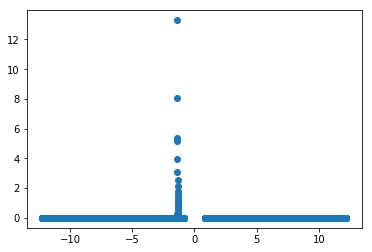

-1.364450837186041 tstart -1.303340134311611 tend
0.08105689227424442 e
test tpeak 0.9260987263466484
[0.92609873] tpeaks
[0.00394061] fwhms
[76.82636278] ampls


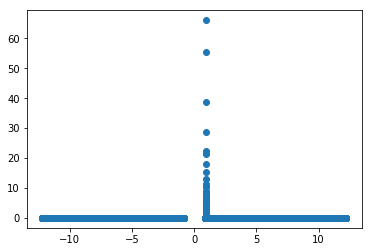

0.9230367157451838 tstart 1.0035922414599554 tend
0.5523898496775601 e
test tpeak 1.5011679090840786
[1.50116791] tpeaks
[0.00285714] fwhms
[45.00520559] ampls


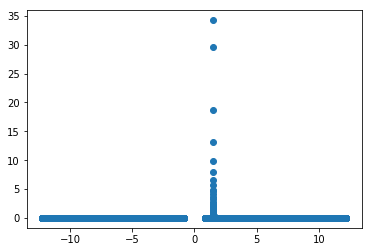

1.4994250818078854 tstart 1.5577583167942066 tend
0.23351887995881418 e
test tpeak 1.985518202189935
[1.9855182] tpeaks
[0.0011911] fwhms
[50.02844571] ampls


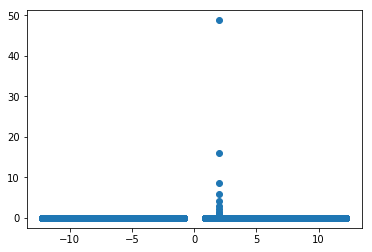

1.9855350939676555 tstart 2.009146135635774 tend
0.13080527179715876 e
test tpeak 2.15007174720866
[2.15007175] tpeaks
[0.02444176] fwhms
[2.23890518] ampls


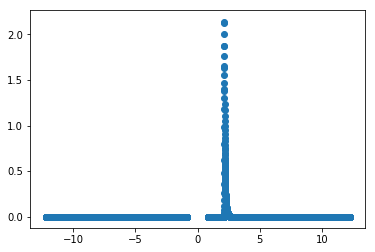

2.125812436107708 tstart 2.6383103967002626 tend
0.09972864617558636 e
test tpeak 2.473977219243044
[2.47397722] tpeaks
[0.00240722] fwhms
[3.03134019] ampls


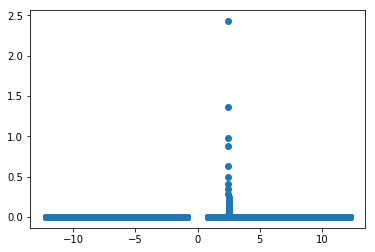

2.4716444700329703 tstart 2.5216442554835794 tend
0.01309681022353579 e
test tpeak 2.852048032400792
[2.85204803] tpeaks
[0.00332683] fwhms
[17.53601599] ampls


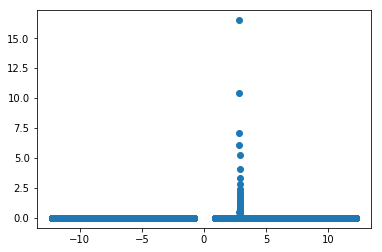

2.849420465704952 tstart 2.917475660420905 tend
0.10732565472220525 e
test tpeak 3.1015721721393543
[3.10157217] tpeaks
[0.00125823] fwhms
[15.45346092] ampls


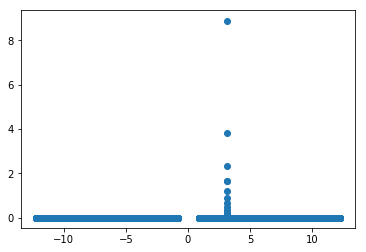

3.1008079627556526 tstart 3.1258078154351097 tend
0.03167774863271844 e
test tpeak 3.1589484626437683
[3.15894846] tpeaks
[0.00092403] fwhms
[233.52731215] ampls


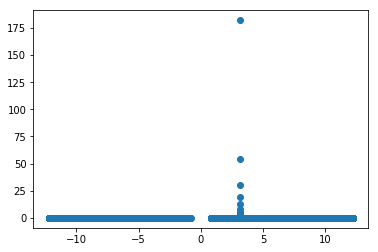

3.1591409495460994 tstart 3.177196396063664 tend
0.44646146563486433 e
test tpeak 3.3149431931366244
[3.31494319] tpeaks
[0.00143742] fwhms
[79.39715523] ampls


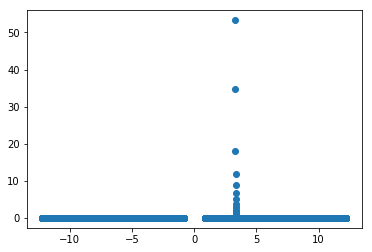

3.3146955392289783 tstart 3.342473138259038 tend
0.21415282864112128 e
test tpeak 4.149569701957077
[4.1495697] tpeaks
[0.00305131] fwhms
[9.225002] ampls


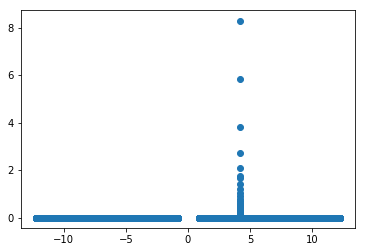

4.146633783186189 tstart 4.210522124844601 tend
0.05203612322316207 e
test tpeak 4.15310595758127
[4.15310596] tpeaks
[0.00498394] fwhms
[0.78563242] ampls


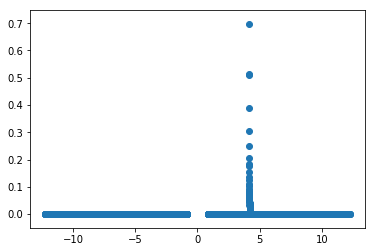

4.149411536988509 tstart 4.252188429094531 tend
0.00710392958709092 e
test tpeak 4.2611259268560175
[4.26112593] tpeaks
[0.00526674] fwhms
[1.37121261] ampls


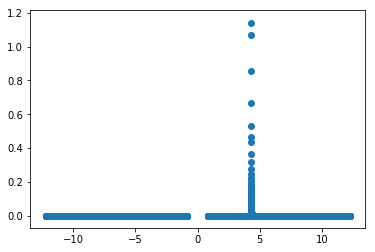

4.256355059099178 tstart 4.3660763056770975 tend
0.01310515543988285 e
test tpeak 4.792129893578595
[4.79212989] tpeaks
[0.00381414] fwhms
[152.43883997] ampls


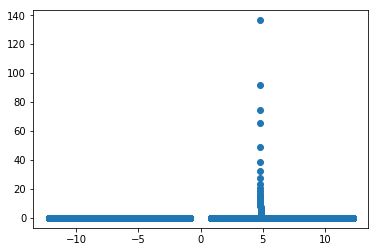

4.789683373888693 tstart 4.867460362092061 tend
1.0563608236991167 e
test tpeak 5.0562559495134245
[5.05625595] tpeaks
[0.00147109] fwhms
[1.53406806] ampls


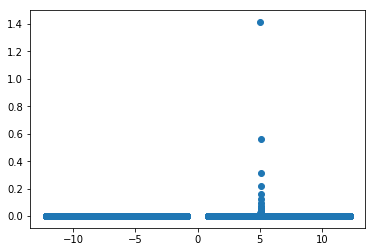

5.054958398501185 tstart 5.085513626070906 tend
0.0044691047203453335 e
test tpeak 5.138547561598987
[5.13854756] tpeaks
[0.00189072] fwhms
[25.51468509] ampls


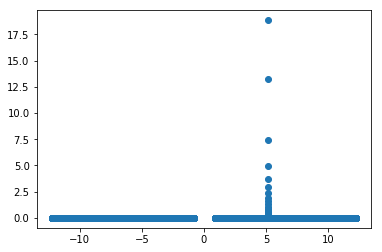

5.136901958036333 tstart 5.175790421403917 tend
0.08914959197484572 e
test tpeak 5.35413213020299
[5.35413213] tpeaks
[0.00239112] fwhms
[68.91558575] ampls


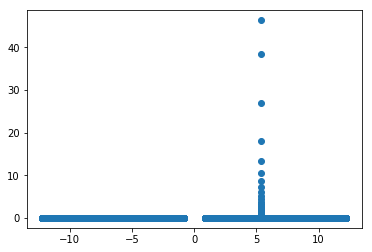

5.352177334102407 tstart 5.400787887584329 tend
0.2939560173653317 e
test tpeak 5.606119939408067
[5.60611994] tpeaks
[0.00199599] fwhms
[14.36156911] ampls


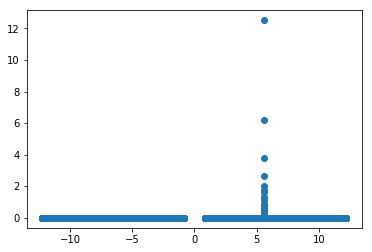

5.604952149718201 tstart 5.645229441326364 tend
0.052744615004264014 e
test tpeak 5.8669147841396025
[5.86691478] tpeaks
[0.00224122] fwhms
[42.89995006] ampls


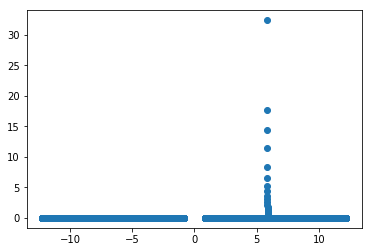

5.866060040012371 tstart 5.9105039201822365 tend
0.1707432611835132 e
test tpeak 6.501347526714745
[6.50134753] tpeaks
[0.00245898] fwhms
[10.98523844] ampls


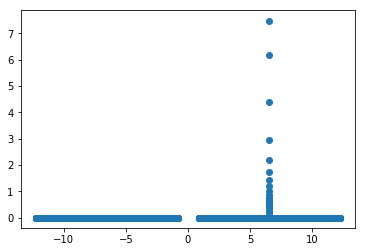

6.499384883534958 tstart 6.549384172590635 tend
0.048219593109858364 e
test tpeak 6.706201206891049
[6.70620121] tpeaks
[0.00132602] fwhms
[28.95185134] ampls


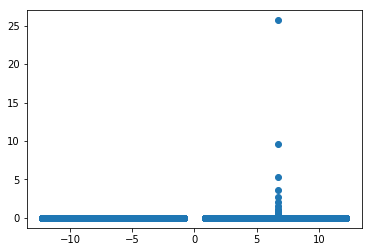

6.704937477046997 tstart 6.732714846973295 tend
0.0763974062581798 e
test tpeak 7.117677784971544
[7.11767778] tpeaks
[0.00258147] fwhms
[17.20396782] ampls


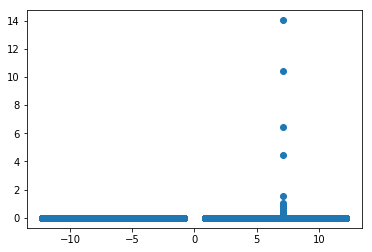

7.116042360460824 tstart 7.168819309255696 tend
0.08807357163348463 e
test tpeak 7.256352124297624
[7.25635212] tpeaks
[0.01342773] fwhms
[0.99137599] ampls


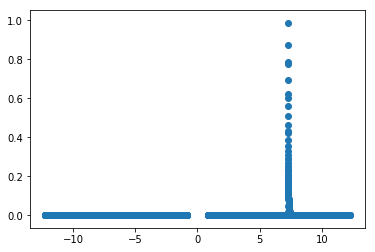

7.2438181199045175 tstart 7.5243691049697645 tend
0.024300376517027825 e
test tpeak 7.279350679052786
[7.27935068] tpeaks
[0.00260026] fwhms
[149.77199217] ampls


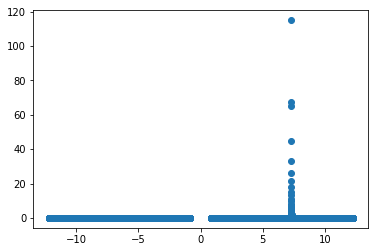

7.2771509201359095 tstart 7.331316714865125 tend
0.6960851087436455 e
test tpeak 7.678720808593642
[7.67872081] tpeaks
[0.00236467] fwhms
[17.67075818] ampls


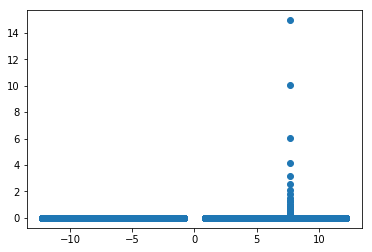

7.677144313362305 tstart 7.725754595363242 tend
0.07746826245139735 e
test tpeak 7.738062001282193
[7.738062] tpeaks
[0.00172468] fwhms
[16.55903727] ampls


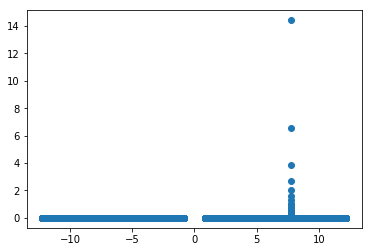

7.736865516046464 tstart 7.771587141257669 tend
0.05316649028942912 e
test tpeak 8.295393336900855
[8.29539334] tpeaks
[0.0015702] fwhms
[60.40627107] ampls


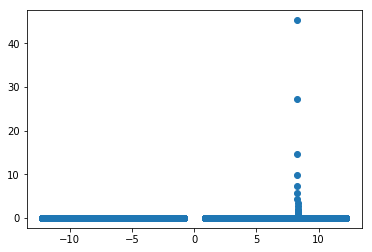

8.29518889278529 tstart 8.325743881005792 tend
0.17966460449950117 e
test tpeak 8.759762246646584
[8.75976225] tpeaks
[0.0087896] fwhms
[2.94444562] ampls


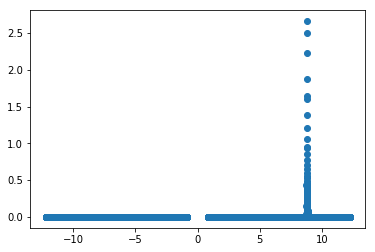

8.752124612648686 tstart 8.935454297499973 tend
0.04708287659063696 e
test tpeak 8.760901428437371
[8.76090143] tpeaks
[0.00184002] fwhms
[2.49007036] ampls


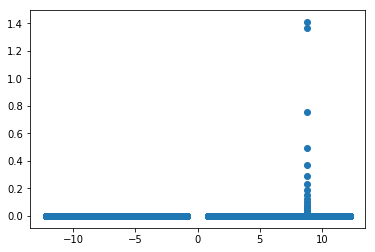

8.759068920553545 tstart 8.796568180359372 tend
0.008185831488487113 e
test tpeak 10.599512100112813
[10.5995121] tpeaks
[0.00269313] fwhms
[8.13088537] ampls


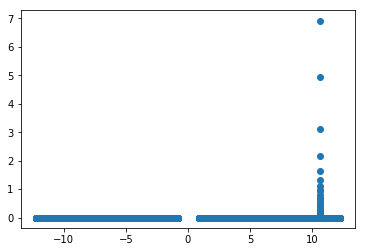

10.597917138800995 tstart 10.652082463677289 tend
0.040344449285259064 e
test tpeak 10.778982245288324
[10.77898225] tpeaks
[0.00231977] fwhms
[23.89260863] ampls


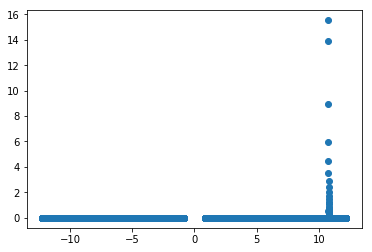

10.777079334499831 tstart 10.824300362181702 tend
0.09905050058096275 e
test tpeak 11.556288981894232
[11.55628898] tpeaks
[0.02901136] fwhms
[2.6320044] ampls


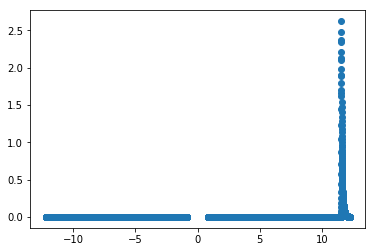

11.528448365081886 tstart 12.13537534018019 tend
0.1392183524085633 e
test tpeak 11.649372331135723
[11.64937233] tpeaks
[0.00099965] fwhms
[20.12087501] ampls


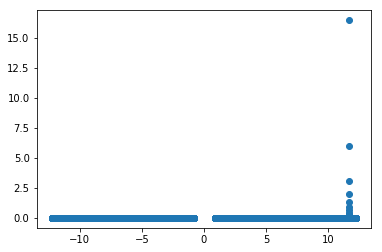

11.649278326966623 tstart 11.66872222407278 tend
0.04389519163639245 e
test tpeak 11.827096080030614
[11.82709608] tpeaks
[0.00146094] fwhms
[29.58063396] ampls


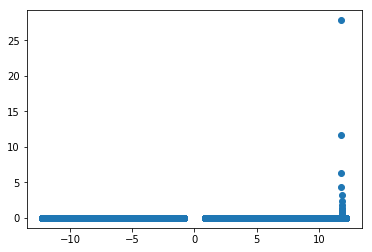

11.825662200290708 tstart 11.856216875585915 tend
0.08847233612302084 e


In [301]:
from scipy import integrate
energy = []
energy_err = []
for i in range(len(tpeaks)):

# i = 2
#     print(i)
#     amp_0 = (trace['ampl'][:,i])
#     q = ((amp_0+1)/1000)
   # a = ((np.median(trace['ampl'][:,i])))#+ 1)/1000)
    #print('***a',a)
    print('test tpeak', np.median(trace['tpeak'][:,i]))
    e = get_flare_integral(x, tpeak = np.median(trace['tpeak'][:,i]),
                                  fwhm = np.median(trace['fwhm'][:,i]),
                                  ampl = np.median(trace['ampl'][:,i]))
    print(e, 'e')
    energy.append(e)


In [302]:
energy_test 
for i in range(len(tpeaks)):
    feval = xoflares.get_light_curvenp(time,
                              tpeak,
                              fwhm,
                              ampl,
                              texp,
                              oversample)
    print(feval, 'feval')
    plt.scatter(time,feval)
    plt.show()
    tstart, tend = time[feval > 0][0], time[feval > 0][-1]
    print(tstart, tend, 'start,end')
    integral = integrate.quad(xoflares.get_light_curvenp, tstart, tend,
                              points = tpeak, args=(time, tpeak, fwhm, ampl))
    

NameError: name 'energy_test' is not defined

In [303]:
print(energy)

[0.06807159064464435, 0.15389365860226256, 0.09077192643098697, 0.1530822516992782, 0.04146487509056989, 0.03470182182160966, 0.1431583044495049, 0.14076703604370122, 0.06193281959716389, 0.25284551371639097, 0.1384798382998146, 0.30127421004727484, 0.03771989656671403, 0.030482141831315115, 0.05033577975648963, 0.20242446575196701, 0.02417732687754143, 0.02631397267141034, 0.082526327783018, 0.05511607576996822, 0.04092885463283047, 0.009488760214799278, 0.06461100592101197, 0.07721599358726408, 0.004540867045620575, 0.08105689227424442, 0.5523898496775601, 0.23351887995881418, 0.13080527179715876, 0.09972864617558636, 0.01309681022353579, 0.10732565472220525, 0.03167774863271844, 0.44646146563486433, 0.21415282864112128, 0.05203612322316207, 0.00710392958709092, 0.01310515543988285, 1.0563608236991167, 0.0044691047203453335, 0.08914959197484572, 0.2939560173653317, 0.052744615004264014, 0.1707432611835132, 0.048219593109858364, 0.0763974062581798, 0.08807357163348463, 0.0243003765170

In [219]:
#energy = [3.2611250291168945, 3.0729757813813015, 3.4997036733169438, 3.047479835022671, 2.781726212285158, 3.2393683985256736, 2.755857501195904, 2.970982804056416, 3.9051236408187964, 2.9657943954003776, 4.745267588830905, 2.7766357620876834, 4.3316396925007865, 3.573563897120984, 2.844202484463976, 3.062288894990368, 3.2565858944071167, 2.9699448971630247, 3.0265079501818484, 2.811295144271944, 2.504295313528813, 4.290489969231964, 2.7489577050764864, 2.779698709031228, 3.249127564572788, 2.581369726411844, 2.864078846518046, 2.8037532611628775, 4.5259134709096065, 2.8264390516903077, 3.126227973341201, 2.5599959573809428, 3.164558012684595, 3.2928869313138383, 2.9192652289735808, 2.8208241102750558, 3.013716582338592, 3.014493883958573, 2.8754777230809836, 2.619165452191111, 3.034655451828816, 3.232362071715586, 3.102592084214075, 3.0772661700890755, 2.7749644564826843, 2.584989988821734, 2.591322633753214, 3.0865871616175617, 2.700597449989372, 3.11052423452587, 3.092360988544616, 2.7927451530228127, 2.8047177343166725, 2.8002256273769803, 2.711240062641297, 5.195464707215417, 2.7263432335198208, 3.508243687140486, 3.0685366534806158, 4.64523098902894, 2.832016183290245]

In [304]:
energy = np.asarray(energy)
d = 1.844e19

integrated_energy = 2.11516010474763e-09 #2139258.107577906

#What is this?? 2.254e10
abs_energy = energy * integrated_energy * 4 * np.pi * (d)**2 
#distance to star, 6 pc, include errors eventually

print(abs_energy)

sort = np.sort(abs_energy)
print(sort)

[6.15234729e+29 1.39089924e+30 8.20401596e+29 1.38356570e+30
 3.74761791e+29 3.13636948e+29 1.29387252e+30 1.27226011e+30
 5.59752183e+29 2.28523147e+30 1.25158829e+30 2.72293265e+30
 3.40914472e+29 2.75499252e+29 4.54937508e+29 1.82952330e+30
 2.18515992e+29 2.37827113e+29 7.45877428e+29 4.98142083e+29
 3.69917209e+29 8.57599296e+28 5.83957777e+29 6.97882339e+29
 4.10406027e+28 7.32596590e+29 4.99252943e+30 2.11055631e+30
 1.18222514e+30 9.01352915e+29 1.18369681e+29 9.70015090e+29
 2.86305211e+29 4.03514295e+30 1.93552488e+30 4.70305305e+29
 6.42057010e+28 1.18445106e+29 9.54744643e+30 4.03920109e+28
 8.05738849e+29 2.65679043e+30 4.76708692e+29 1.54318686e+30
 4.35811298e+29 6.90483902e+29 7.96013719e+29 2.19628121e+29
 6.29125498e+30 7.00162359e+29 4.80521624e+29 1.62381844e+30
 4.25537593e+29 7.39839891e+28 3.64635321e+29 8.95223798e+29
 1.25826302e+30 3.96727123e+29 7.99617774e+29]
[4.03920109e+28 4.10406027e+28 6.42057010e+28 7.39839891e+28
 8.57599296e+28 1.18369681e+29 1.18445

22.724999999999998


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys


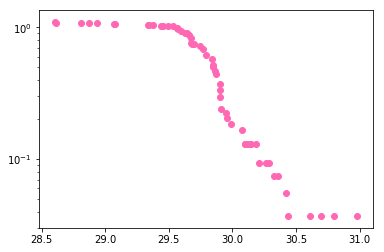

In [305]:
time_duration = (len(l.time)*2 / 60 / 24)
print(time_duration)
#time_duration = 25.130555555555556

log_sort = np.log10(sort)
n_bins = len(log_sort)
counts, bin_edges = np.histogram(log_sort, bins=n_bins, normed=True)
cdf = np.cumsum(counts)

# sns.set_style("white")
# plt.figure(figsize=(18,13))
# plt.scatter(bin_edges[:-1], (len(log_sort)- cdf)/time_duration)

x = []
y= []
for i in range(len(log_sort)):
    x.append(log_sort[i])
    y.append(cdf[i]/time_duration)

x = x[::-1]
plt.yscale('log')
plt.scatter(x,y, c='hotpink')

22.724999999999998
59


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


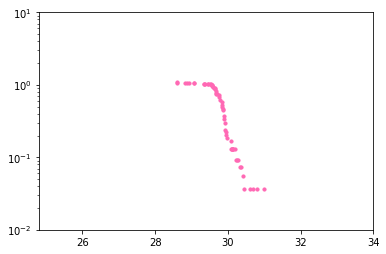

In [306]:
time_duration = (len(l.time)*2 / 60 / 24)
print(time_duration)
#time_duration = 25.130555555555556

log_sort = np.log10(sort)
n_bins = len(log_sort)
print(n_bins)
counts, bin_edges = np.histogram(log_sort, bins=n_bins, normed=True)
cdf = np.cumsum(counts)

# sns.set_style("white")
# plt.figure(figsize=(18,13))
# plt.scatter(bin_edges[:-1], (len(log_sort)- cdf)/time_duration)

x_plot = []
y_plot= []
for i in range(len(log_sort)):
    x_plot.append(log_sort[i])
    y_plot.append(cdf[i]/time_duration)

x_plot = x_plot[::-1]
plt.yscale('log')
plt.ylim(0.01,10)
plt.xlim(24.8,34)
plt.scatter(x_plot,y_plot, c='hotpink',s=10)

In [125]:
l = Lightcurve()
l.add_data('YZ CMi')

code runs lc.flatten()


In [126]:
o = OddsRatioDetector(l)
lnO, ts = o.oddsratio()
flarelist, Nflares, maxlist = o.thresholder(lnO, thresh = 10, expand=0, returnmax=True)

In [127]:
# print(flarelist)
print(len(maxlist))

59


In [128]:
a = []
for i in range(len(flarelist)):
    x1 = (flarelist[i][1]) - (flarelist[i][0])
    y1 = maxlist[i][0]
    a.append(x1 * y1)

print(len(a))
print(a)

59
[263.0616034791701, 41824.70638891729, 1698.1889154813405, 6725.930468996866, 84.59716703643176, 21.565779357359876, 29756.670356474497, 2426.73355897349, 162.48501440674062, 393.24456068756456, 220.80575487218184, 58699.29998062139, 22.922713700534747, 26.70379966447276, 95.52193348474692, 44857.05079046125, 47.25699872105544, 48.524855852103315, 608.1714933626953, 46.21845690398417, 27.941978565264602, 20.591492714230462, 125.49006574415564, 195.10026151691426, 21.76477469258553, 388.1766871657206, 368818.0230172962, 19253.68683982425, 3414.123705853851, 115.77316114357865, 11.368384738610368, 2629.0213192585506, 33.71687358560147, 382885.391556257, 30138.591195213623, 50.40781001921679, 37.12977684860091, 35.08855362143339, 1858554.9011842331, 10.673059978650038, 1654.9314258916295, 91748.53046999787, 233.43303320354727, 8457.926039889191, 142.15063201546124, 1542.7582926788355, 309.53641491475537, 127.94358663407627, 457404.384033912, 942.2607197694507, 317.97330975543576, 13239

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


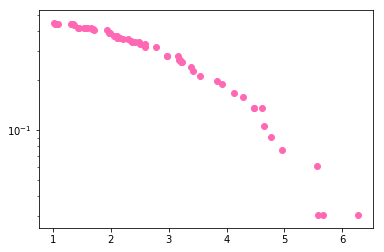

In [129]:
sort = np.sort(a)
log_sort = np.log10(sort)

time_duration = 25.130555555555556
counts, bin_edges = np.histogram(log_sort, bins=59, normed=True)
cdf = np.cumsum(counts)

# sns.set_style("white")
# plt.figure(figsize=(18,13))
# plt.scatter(bin_edges[:-1], (len(log_sort)- cdf)/time_duration)

x = []
y= []
for i in range(len(log_sort)):
    x.append(log_sort[i])
    y.append(cdf[i]/time_duration)

x = x[::-1]
plt.yscale('log')
plt.scatter(x,y, c='hotpink')